First:
- go to the terminal
- go to the `4_tuning_networks` folder, use `cd` to get there, or `z` to get there faster.
- if you are planning on closing the laptop to let this run by itself, start a tmux session by giving the command `tmux`. You can name the session with `ctrl+b $`, leave the tmux with `ctrl+b` d, access it again with `tmux a -t 0` or replace the 0 with the name you gave it. See [tmux](https://github.com/tmux/tmux/wiki/Getting-Started) for more info.
- Activate the `.venv`, and run `python hypertune.py`
- In the hypertune.py file, a tune_dir is specified: `models/ray`. We will check the contents of that folder after the hypertune finished. You can also use tensorboard to check the results. 
- this will take some time. I clocked 1901 seconds (30 minutes) on the VM

 0.0992908 |           119 |            3 |     26 |         576.744  |    0 |   0.942187

In [31]:
from ray.tune import ExperimentAnalysis
import ray
ray.init(ignore_reinit_error=True)

2024-12-16 16:28:59,164	INFO worker.py:1652 -- Calling ray.init() again after it has already been called.


Python version:,3.10.14
Ray version:,2.39.0


In [309]:
import pandas as pd
results_df_CNN = pd.DataFrame()
results_df_LSTM = pd.DataFrame()

In [310]:
def get_dropout_position(row):
    if row['dropout1'] > 0:
        return "After convolution"
    elif row['dropout2'] > 0:
        return "Before the pooling"
    elif row['dropout3'] > 0:
        return "In dense layer"
    return None  # In case all dropouts are zero

In [311]:
from pathlib import Path
tune_dir = Path("models/ray").resolve()
tune_dir.exists()
tunelogs = [d for d in tune_dir.iterdir()]
tunelogs.sort()
tunelogs

[WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/src/models/ray/train_2024-12-16_18-29-56'),
 WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/src/models/ray/train_2024-12-16_18-33-55'),
 WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/src/models/ray/train_2024-12-16_18-48-45'),
 WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/src/models/ray/train_2024-12-16_19-33-38'),
 WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/src/models/ray/train_2024-12-16_19-36-03'),
 WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/src/models/ray/train_2024-12-16_19-39-58'),
 WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/src/models/ray/train_2024-12-16_19-46-46'),
 WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/src/

In [312]:
tunelogs = [d for d in tune_dir.iterdir()]
tunelogs.sort()
latest = tunelogs[-1]
latest
Path(latest).name

'train_2024-12-16_21-43-31'

In [313]:
for logs in tunelogs:
    
    #load res
    analysis = ExperimentAnalysis(logs)
    df ={}
    df = analysis.dataframe()
    if 'config/filters' in df.columns:
        print('cnn', Path(logs).name)
        
        df = df[['Accuracy','iterations', 'config/filters', 'config/dropout1','config/dropout2', 'config/dropout3',
               'config/units1', 'config/units2',
               'config/model_type']]
        
        df.sort_values('Accuracy', inplace=True, ascending=False)
        df['experiment'] = Path(logs).name.replace('train_', "")
        results_df_CNN = pd.concat([results_df_CNN, df])
       
    elif 'config/hidden_size' in df.columns:
        print('lstm', Path(logs).name)
        if 'config/units1' in df.columns:
            print('units')
            df = df[['Accuracy','iterations', 'config/hidden_size', 'config/dropout', 'config/num_layers', 'config/units1', 'config/units2','config/model_type']]
        else:
            df = df[['Accuracy','iterations', 'config/hidden_size', 'config/dropout', 'config/num_layers','config/model_type']]
        df.sort_values('Accuracy', inplace=True, ascending=False)
        df['experiment'] = Path(logs).name.replace('train_', "")
        results_df_LSTM = pd.concat([results_df_LSTM, df])
        
    else:
        print(f'Could not find any trainlogs: {logs}')



lstm train_2024-12-16_18-29-56
lstm train_2024-12-16_18-33-55
lstm train_2024-12-16_18-48-45
cnn train_2024-12-16_19-33-38
cnn train_2024-12-16_19-36-03
cnn train_2024-12-16_19-39-58
cnn train_2024-12-16_19-46-46
cnn train_2024-12-16_19-49-55
Could not find any trainlogs: C:\Users\Francesca\Documents\osint\code_repo\AI\MADS-MachineLearning-FP\src\models\ray\train_2024-12-16_19-51-55
lstm train_2024-12-16_19-54-14
cnn train_2024-12-16_21-04-46
cnn train_2024-12-16_21-43-31


In [314]:
results_df_LSTM.columns = ['accuracy', 'iterations', 'hidden_size', 'dropout', 'num_layers', 'model_type', 'experiment']
results_df_LSTM.sort_values(by = ['accuracy', 'iterations'], inplace=True, ascending=False)
results_df_LSTM.reset_index(inplace=True, drop=True)
results_df_LSTM

,accuracy,iterations,hidden_size,dropout,num_layers,model_type,experiment
0,0.985938,9,650,0.0,2,LSTM,2024-12-16_19-54-14
1,0.926562,9,180,0.0,2,LSTM,2024-12-16_18-29-56
2,0.914062,9,177,0.0,2,LSTM,2024-12-16_18-33-55
3,0.912500,9,139,0.0,3,LSTM,2024-12-16_18-33-55
4,0.867188,8,295,0.0,3,LSTM,2024-12-16_18-29-56
5,0.795312,9,93,0.0,2,LSTM,2024-12-16_18-48-45
6,0.723437,9,93,0.0,3,LSTM,2024-12-16_18-48-45
7,0.606250,9,73,0.0,3,LSTM,2024-12-16_18-48-45
8,0.565625,9,379,0.0,4,LSTM,2024-12-16_19-54-14
9,0.400000,8,71,0.0,6,LSTM,2024-12-16_18-48-45


In [315]:
results_df_LSTM.columns
data = results_df_LSTM.copy()
data.drop(['model_type', 'dropout'], axis=1, inplace=True)
data_lstm = data[data['iterations']==9]
data_lstm

,accuracy,iterations,hidden_size,num_layers,experiment
0,0.985938,9,650,2,2024-12-16_19-54-14
1,0.926562,9,180,2,2024-12-16_18-29-56
2,0.914062,9,177,2,2024-12-16_18-33-55
3,0.912500,9,139,3,2024-12-16_18-33-55
5,0.795312,9,93,2,2024-12-16_18-48-45
6,0.723437,9,93,3,2024-12-16_18-48-45
7,0.606250,9,73,3,2024-12-16_18-48-45
8,0.565625,9,379,4,2024-12-16_19-54-14
11,0.335938,9,37,6,2024-12-16_18-48-45


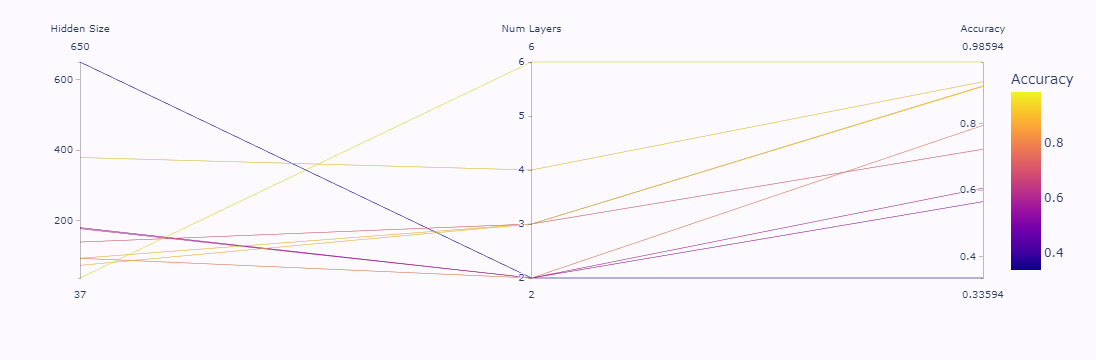

<Figure size 640x480 with 0 Axes>

In [327]:
import plotly.express as px


select = [ "hidden_size", "num_layers", "accuracy",]
p = data_lstm[select].reset_index(drop=True).dropna()
p.sort_values("accuracy", inplace=True)
# Create the parallel coordinates plot
px.parallel_coordinates(p, color="accuracy", 
                              labels={"accuracy": "Accuracy", "hidden_size": "Hidden Size", "num_layers": "Num Layers"})
plt.savefig("LSTM_experiment1.jpg", bbox_inches='tight', transparent=False)

# Show the plot
fig.show()

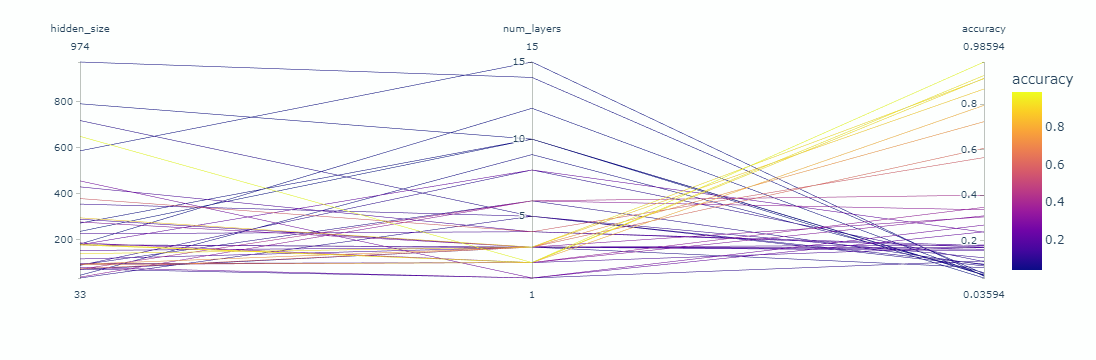

In [317]:
import plotly.express as px
select = [ "hidden_size", "num_layers", "accuracy",]
p = results_df_LSTM[select].reset_index(drop=True).dropna()

px.parallel_coordinates(p, color="accuracy")

In [318]:
results_df_CNN.columns = ['accuracy', 'iterations', 'filters', 'dropout1', 'dropout2', 'dropout3', 'units1', 'units2',
        'model_type', 'experiment']
results_df_CNN.sort_values(by = ['accuracy', 'iterations'], inplace=True, ascending=False)
results_df_CNN.reset_index(inplace=True, drop=True)
results_df_CNN.columns

Index(['accuracy', 'iterations', 'filters', 'dropout1', 'dropout2', 'dropout3',
       'units1', 'units2', 'model_type', 'experiment'],
      dtype='object')

In [319]:
results_df_CNN['dropout_position'] = results_df_CNN.apply(get_dropout_position, axis=1)

In [320]:
results_df_CNN.sort_values(by = ['iterations','accuracy', 'experiment',  'filters', 'experiment'], inplace=True, ascending=False)
##results_df.reset_index(inplace=True, drop=True)
results_df_CNN['total_units'] = results_df_CNN['units1']+results_df_CNN['units1']
data_cnn = results_df_CNN[results_df_CNN['iterations']==9]
data_cnn

,accuracy,iterations,filters,dropout1,dropout2,dropout3,units1,units2,model_type,experiment,dropout_position,total_units
0,0.996875,9,100,0.039384,0.000000,0.000000,154,493,CNN,2024-12-16_19-49-55,After convolution,308
1,0.993750,9,100,0.017562,0.000000,0.000000,369,144,CNN,2024-12-16_19-33-38,After convolution,738
2,0.990625,9,100,0.000000,0.031117,0.000000,82,127,CNN,2024-12-16_21-43-31,Before the pooling,164
3,0.989062,9,100,0.000000,0.000000,0.074018,358,174,CNN,2024-12-16_19-46-46,In dense layer,716
4,0.987500,9,100,0.000000,0.019090,0.000000,305,161,CNN,2024-12-16_19-36-03,Before the pooling,610
5,0.985938,9,100,0.000000,0.000000,0.162804,333,180,CNN,2024-12-16_19-39-58,In dense layer,666
7,0.981250,9,100,0.000000,0.135470,0.000000,165,286,CNN,2024-12-16_21-04-46,Before the pooling,330
16,0.965625,9,100,0.071967,0.000000,0.000000,191,401,CNN,2024-12-16_19-49-55,After convolution,382
24,0.950000,9,100,0.000000,0.000000,0.097945,218,144,CNN,2024-12-16_19-39-58,In dense layer,436


### Experiment 2: CNN units vs dropout positions

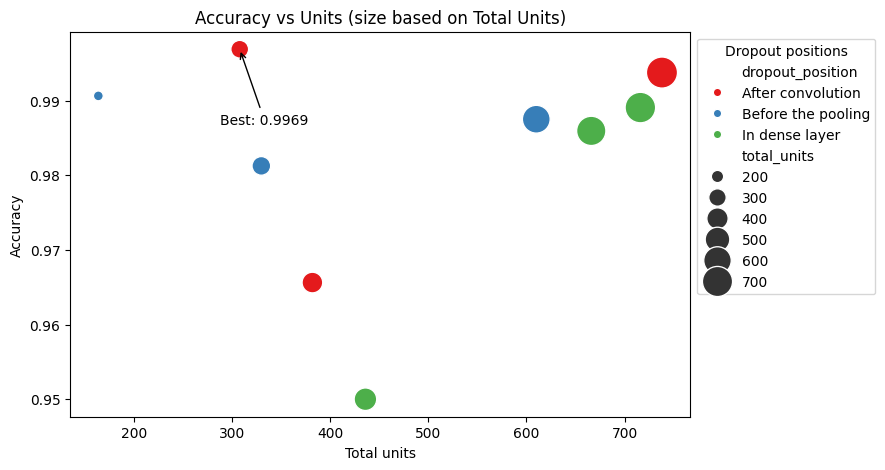

In [322]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=data_cnn, x="total_units", y="accuracy", hue="dropout_position", size="total_units", sizes=(50, 500), palette="Set1")

plt.title("Accuracy vs Units (size based on Total Units)")
plt.ylabel("Accuracy")
plt.xlabel("Total units")
# Annotate the best configuration point
plt.annotate(f"Best: {best_config['accuracy']:.4f}", 
             xy=(best_config['total_units'], best_config['accuracy']),
             xytext=(best_config['total_units'] - 20, best_config['accuracy'] - 0.01),  # Move annotation to the left
             arrowprops=dict(arrowstyle='->', lw=1),
             fontsize=10, color='black')


plt.legend(title="Dropout positions", bbox_to_anchor=(1.0, 1), loc='upper left')

plt.savefig("CNN_experiment_size_based.jpg", bbox_inches='tight', transparent=False)
plt.show()


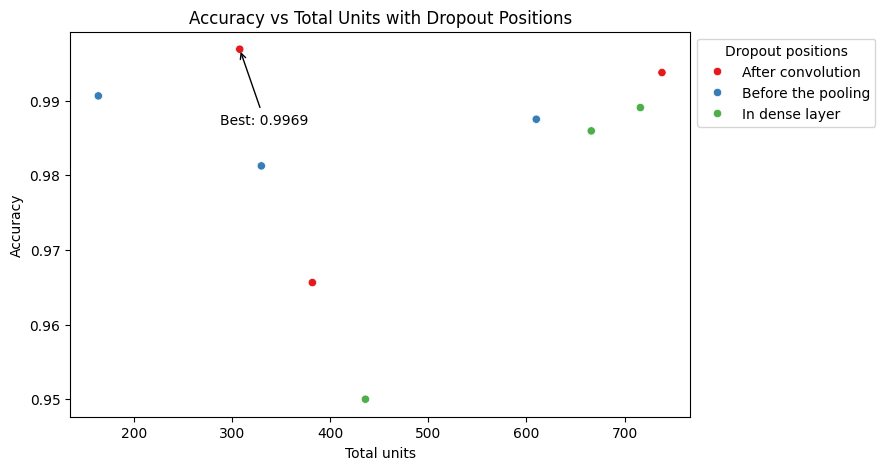

In [321]:
# Identify the row with the highest accuracy
best_config = data_cnn.loc[data_cnn['accuracy'].idxmax()]

# Create the plot
plt.figure(figsize=(8, 5))
fig = sns.scatterplot(data=data_cnn, x="total_units", y="accuracy", hue="dropout_position", palette="Set1")

# Annotate the best configuration point (placing the annotation on the left)
plt.annotate(f"Best: {best_config['accuracy']:.4f}", 
             xy=(best_config['total_units'], best_config['accuracy']),
             xytext=(best_config['total_units'] - 20, best_config['accuracy'] - 0.01),  # Move annotation to the left
             arrowprops=dict(arrowstyle='->', lw=1),
             fontsize=10, color='black')

# Set plot title and labels
plt.title("Accuracy vs Total Units with Dropout Positions")
plt.ylabel("Accuracy")
plt.xlabel("Total units")

# Add the legend
plt.legend(title="Dropout positions", bbox_to_anchor=(1.0, 1), loc='upper left')



# Save the plot
plt.savefig("CNN_experiment_with_annotations_left.jpg", bbox_inches='tight', transparent=False)
# Show the plot
plt.show()

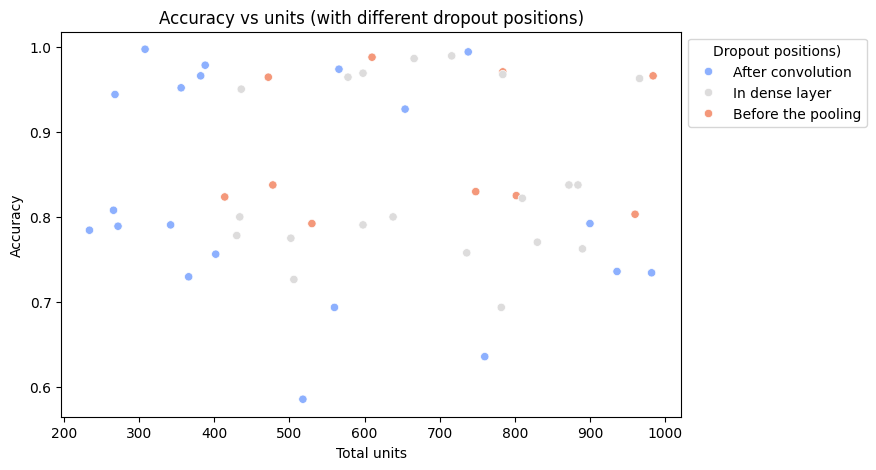

In [217]:
plt.figure(figsize=(8, 5))
fig =sns.scatterplot(data=results_df_CNN, x="total_units", y="accuracy", hue="dropout_position", palette="coolwarm")
plt.title("Accuracy vs units (with different dropout positions)")
plt.ylabel("Accuracy")
plt.xlabel("Total units")
plt.legend(title="Dropout positions)", bbox_to_anchor=(1.0, 1), loc='upper left')

plt.savefig("CNN_experiment.jpg", bbox_inches='tight', transparent=False)
plt.show()

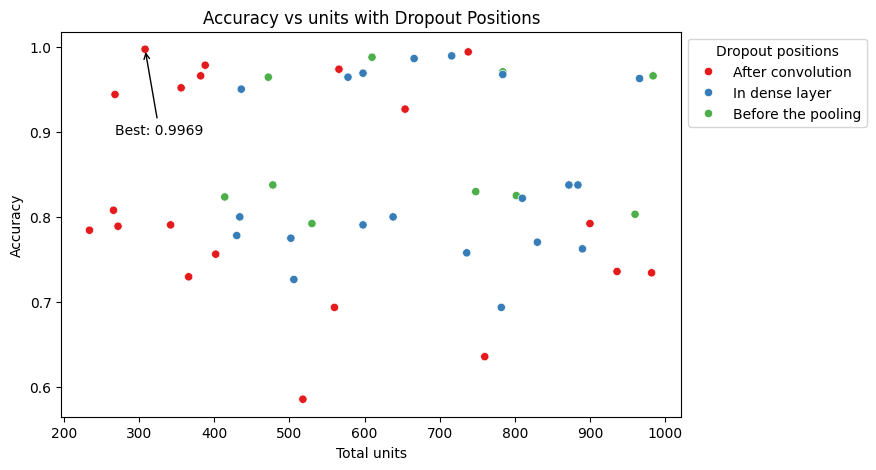

In [232]:
# Identify the row with the highest accuracy
best_config = results_df_CNN.loc[results_df_CNN['accuracy'].idxmax()]

plt.figure(figsize=(8, 5))
fig = sns.scatterplot(data=results_df_CNN, x="total_units", y="accuracy", hue="dropout_position", palette="Set1")

# Annotate the best configuration point
plt.annotate(f"Best: {best_config['accuracy']:.4f}", 
             xy=(best_config['total_units'], best_config['accuracy']),
             xytext=(best_config['total_units'] - 40, best_config['accuracy'] - 0.1),
             arrowprops=dict(arrowstyle='->', lw=1),
             fontsize=10, color='black')

plt.title("Accuracy vs units with Dropout Positions")
plt.ylabel("Accuracy")
plt.xlabel("Total units")
plt.legend(title="Dropout positions", bbox_to_anchor=(1.0, 1), loc='upper left')


plt.savefig("CNN_experiment_with_annotations.jpg", bbox_inches='tight', transparent=False)
plt.show()

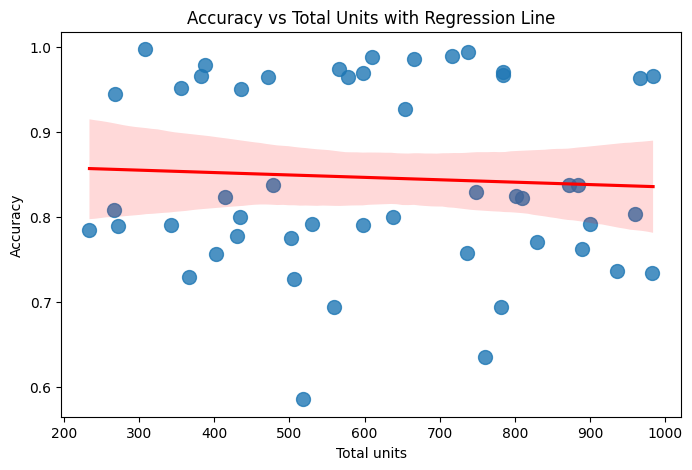

In [220]:
plt.figure(figsize=(8, 5))
fig = sns.regplot(data=results_df_CNN, x="total_units", y="accuracy", scatter_kws={"s": 100}, line_kws={"color": "red"})

plt.title("Accuracy vs Total Units with Regression Line")
plt.ylabel("Accuracy")
plt.xlabel("Total units")


plt.savefig("img/CNN_experiment_with_regression_line.jpg", bbox_inches='tight', transparent=False)
plt.show()

In [131]:
expB = results_df_CNN[results_df_CNN['dropout'] > 0]

In [100]:
results_df_LSTM.columns

Index(['Accuracy', 'iterations', 'config/hidden_size', 'config/dropout',
       'config/num_layers', 'config/model_type', 'experiment'],
      dtype='object')

In [101]:
results_df_LSTM.columns = ['accuracy', 'iterations', 'hidden_size', 'dropout',
       'num_layers', 'model_type', 'experiment']
results_df_LSTM.sort_values(by = ['accuracy', 'iterations'], inplace=True, ascending=False)
results_df_LSTM.reset_index(inplace=True, drop=True)


In [102]:
results_df_LSTM.head(20)

,accuracy,iterations,hidden_size,dropout,num_layers,model_type,experiment
0,0.995313,24,222,0.000000,2,LSTM,2024-12-16_16-37-36
1,0.992188,49,192,0.023138,3,LSTM,2024-12-16_16-16-54
2,0.989062,24,154,0.000000,3,LSTM,2024-12-16_16-31-18
3,0.978125,24,117,0.196324,3,LSTM,2024-12-16_17-27-22
4,0.967187,24,124,0.000000,4,LSTM,2024-12-16_16-37-36
5,0.759375,8,232,0.075960,3,LSTM,2024-12-16_16-16-54
6,0.748437,8,193,0.054834,3,LSTM,2024-12-16_16-16-54
7,0.539062,8,178,0.000000,4,LSTM,2024-12-16_16-37-36
8,0.496875,8,205,0.000000,5,LSTM,2024-12-16_16-37-36
9,0.393750,2,128,0.000000,3,LSTM,2024-12-16_16-31-18


In [49]:
results_df_LSTM.head(20)

,accuracy,iterations,hidden_size,dropout,num_layers,model_type,experiment
0,0.995313,24,222,0.000000,2,LSTM,2024-12-16_16-37-36
1,0.992188,49,192,0.023138,3,LSTM,2024-12-16_16-16-54
2,0.989062,24,154,0.000000,3,LSTM,2024-12-16_16-31-18
3,0.967187,24,124,0.000000,4,LSTM,2024-12-16_16-37-36
4,0.759375,8,232,0.075960,3,LSTM,2024-12-16_16-16-54
5,0.748437,8,193,0.054834,3,LSTM,2024-12-16_16-16-54
6,0.539062,8,178,0.000000,4,LSTM,2024-12-16_16-37-36
7,0.496875,8,205,0.000000,5,LSTM,2024-12-16_16-37-36
8,0.393750,2,128,0.000000,3,LSTM,2024-12-16_16-31-18
9,0.365625,2,249,0.000000,3,LSTM,2024-12-16_16-31-18


### Report results

In [103]:
report = {}

In [104]:
expA_cnn = results_df_CNN[results_df_CNN['dropout'] == 0][:3]
expA_ltm = results_df_LSTM[results_df_LSTM['dropout'] == 0][:3]
ExpA_top3 = pd.concat([expA_cnn, expA_ltm])
ExpA_top3

,accuracy,iterations,filters,dropout,num_layers,units1,units2,model_type,experiment,hidden_size
1,0.996875,24,169.0,0.0,3,307.0,109.0,CNN,2024-12-16_17-40-34,NaN
4,0.993750,24,295.0,0.0,2,412.0,160.0,CNN,2024-12-16_16-58-13,NaN
3,0.993750,24,139.0,0.0,2,317.0,155.0,CNN,2024-12-16_16-58-13,NaN
0,0.995313,24,NaN,0.0,2,NaN,NaN,LSTM,2024-12-16_16-37-36,222.0
2,0.989062,24,NaN,0.0,3,NaN,NaN,LSTM,2024-12-16_16-31-18,154.0
4,0.967187,24,NaN,0.0,4,NaN,NaN,LSTM,2024-12-16_16-37-36,124.0


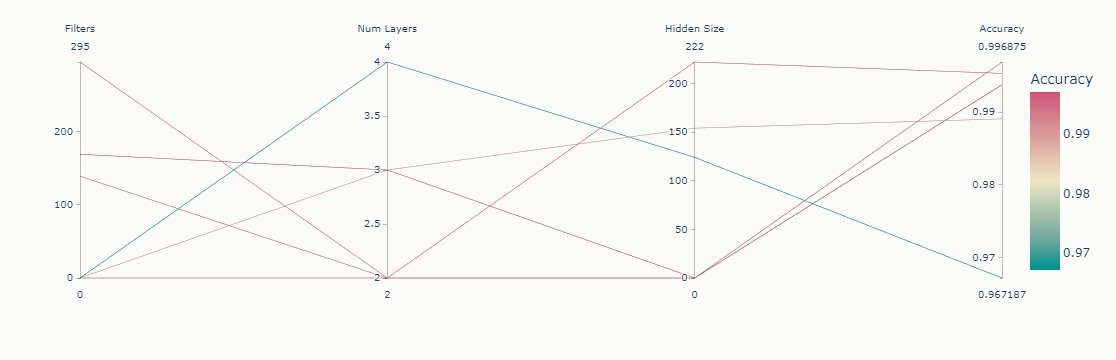

In [120]:
import plotly.express as px

data_cleaned = data.fillna(0)  # Replace NaN with 0 for visualization
fig = px.parallel_coordinates(
    data_cleaned,
    dimensions=[ "filters", "num_layers", "hidden_size", "accuracy"],
    color="accuracy",
    labels={"accuracy": "Accuracy", "filters": "Filters", "dropout": "Dropout", 
            "num_layers": "Num Layers", "hidden_size": "Hidden Size"},
    color_continuous_scale=px.colors.diverging.Tealrose,
)
fig.show()

In [105]:
expB_cnn = results_df_CNN[results_df_CNN['dropout'] > 0][:3]
expB_ltm = results_df_LSTM[results_df_LSTM['dropout'] > 0][:3]
ExpB_top3 = pd.concat([expB_cnn, expB_ltm])
ExpB_top3

,accuracy,iterations,filters,dropout,num_layers,units1,units2,model_type,experiment,hidden_size
0,0.996875,24,104.0,0.159089,2,244.0,121.0,CNN,2024-12-16_17-14-32,NaN
2,0.995313,24,259.0,0.018726,3,283.0,166.0,CNN,2024-12-16_17-14-32,NaN
7,0.979688,8,240.0,0.009168,3,445.0,107.0,CNN,2024-12-16_17-14-32,NaN
1,0.992188,49,NaN,0.023138,3,NaN,NaN,LSTM,2024-12-16_16-16-54,192.0
3,0.978125,24,NaN,0.196324,3,NaN,NaN,LSTM,2024-12-16_17-27-22,117.0
5,0.759375,8,NaN,0.075960,3,NaN,NaN,LSTM,2024-12-16_16-16-54,232.0


In [77]:
top_5_cnn = results_df_CNN[:3]
top_5_lstm = results_df_LSTM[:3]
top5 = pd.concat([top_5_cnn, top_5_lstm])

In [78]:
top5.fillna(0)
top5

,accuracy,iterations,filters,dropout,num_layers,units1,units2,model_type,experiment,hidden_size
0,0.996875,24,104.0,0.159089,2,244.0,121.0,CNN,2024-12-16_17-14-32,NaN
1,0.995313,24,259.0,0.018726,3,283.0,166.0,CNN,2024-12-16_17-14-32,NaN
3,0.993750,24,295.0,0.000000,2,412.0,160.0,CNN,2024-12-16_16-58-13,NaN
0,0.995313,24,NaN,0.000000,2,NaN,NaN,LSTM,2024-12-16_16-37-36,222.0
1,0.992188,49,NaN,0.023138,3,NaN,NaN,LSTM,2024-12-16_16-16-54,192.0
2,0.989062,24,NaN,0.000000,3,NaN,NaN,LSTM,2024-12-16_16-31-18,154.0


In [79]:
from tabulate import tabulate
def create_report_md(report_df):
    # Convert to Markdown table
    markdown_table = tabulate(report_df, headers="keys", tablefmt="pipe")
    
    # Print or save the Markdown table
    print(markdown_table)
    return markdown_table

def report_top_results(results_df, top=5):
    report={}
    top_5 = results_df[:top]
    for col in top_5.columns:
        report[col] = "<br>".join(map(str, top_5[col]))
    # Convert report into a DataFrame if needed
    report_df = pd.DataFrame([report])
    #print(report_df.columns) 
    #report_df.columns = ['accuracy', 'iterations', 'filters', 'hidden_size' 'dropout', 'num_layers', 'units1', 'units2', 'model_type', 'experiment']
    
    report_df.drop(['experiment'], axis=1, inplace=True)
    markdown_table = create_report_md(report_df)
    return report_df

In [80]:
report_top_results(top_5_cnn)

|    | accuracy                         | iterations     | filters           | dropout                                            | num_layers   | units1            | units2            | model_type        |
|---:|:---------------------------------|:---------------|:------------------|:---------------------------------------------------|:-------------|:------------------|:------------------|:------------------|
|  0 | 0.996875<br>0.9953125<br>0.99375 | 24<br>24<br>24 | 104<br>259<br>295 | 0.15908916014631036<br>0.018726416613307494<br>0.0 | 2<br>3<br>2  | 244<br>283<br>412 | 121<br>166<br>160 | CNN<br>CNN<br>CNN |


,accuracy,iterations,filters,dropout,num_layers,units1,units2,model_type
0,0.996875<br>0.9953125<br>0.99375,24<br>24<br>24,104<br>259<br>295,0.15908916014631036<br>0.018726416613307494<br...,2<br>3<br>2,244<br>283<br>412,121<br>166<br>160,CNN<br>CNN<br>CNN


In [81]:
report_top_results(top_5_lstm)

|    | accuracy                            | iterations     | hidden_size       | dropout                           | num_layers   | model_type           |
|---:|:------------------------------------|:---------------|:------------------|:----------------------------------|:-------------|:---------------------|
|  0 | 0.9953125<br>0.9921875<br>0.9890625 | 24<br>49<br>24 | 222<br>192<br>154 | 0.0<br>0.02313795378598019<br>0.0 | 2<br>3<br>3  | LSTM<br>LSTM<br>LSTM |


,accuracy,iterations,hidden_size,dropout,num_layers,model_type
0,0.9953125<br>0.9921875<br>0.9890625,24<br>49<br>24,222<br>192<br>154,0.0<br>0.02313795378598019<br>0.0,2<br>3<br>3,LSTM<br>LSTM<br>LSTM


In [339]:
report_lstm=
top_5_cnn = results_df_CNN[:5]
for col in top_5_cnn.columns:
    report_cnn[col] = "<br>".join(map(str, top_5_cnn[col]))

NameError: name 'report_cnn' is not defined

In [316]:
report_lstm ={}
top_5_lstm = results_df_LSTM[:5]
for col in top_5_lstm.columns:
    report_lstm[col] = "<br>".join(map(str, top_5_lstm[col]))

In [317]:
report


{'Accuracy': '0.996875<br>0.9953125<br>0.9953125<br>0.99375<br>0.99375',
 'iterations': '49<br>49<br>49<br>26<br>49',
 'config/filters': '50<br>51<br>88<br>25<br>50',
 'config/dropout': '0.0<br>0.0<br>0.0<br>0.028778651031632952<br>0.0',
 'config/num_layers': '4<br>4<br>4<br>3<br>4',
 'config/units1': '105<br>191<br>109<br>68<br>379',
 'config/units2': '375<br>304<br>357<br>285<br>959',
 'config/model_type': 'CNN<br>CNN<br>CNN<br>CNN<br>CNN',
 'experiment': '2024-12-16_12-02-16<br>2024-12-16_12-36-36<br>2024-12-16_12-02-16<br>2024-12-16_12-36-36<br>2024-12-16_12-36-36',
 'accuracy': '0.9921875<br>0.990625<br>0.9890625<br>0.984375<br>0.98125',
 'filters': '50<br>51<br>88<br>50<br>25',
 'dropout': '0.0<br>0.0<br>0.0<br>0.0<br>0.0',
 'num_layers': '3<br>3<br>3<br>4<br>3',
 'units1': '105<br>191<br>109<br>210<br>68',
 'units2': '375<br>304<br>357<br>551<br>285',
 'model_type': 'LSTM<br>LSTM<br>LSTM<br>LSTM<br>LSTM',
 'hidden_size': '96<br>234<br>119<br>238<br>118'}

In [221]:
# Convert report into a DataFrame if needed
report_df = pd.DataFrame([report])
report_df.columns = ['accuracy', 'iterations', 'filters', 'dropout',
       'num_layers', 'units1', 'units2',
       'model_type', 'experiment']
#report_df.drop(['model_type'], axis=1, inplace=True)
report_df['date'] = report_df['experiment'].str.replace('train_', "")
report_df.drop(['experiment'], axis=1, inplace=True)

In [222]:

# Convert to Markdown table
markdown_table = tabulate(report_df, headers="keys", tablefmt="pipe")

# Print or save the Markdown table
print(markdown_table)

|    | accuracy                                                 | iterations                 | filters                    | dropout                                          | num_layers            | units1                         | units2                          | model_type                      | date                                                                                                            |
|---:|:---------------------------------------------------------|:---------------------------|:---------------------------|:-------------------------------------------------|:----------------------|:-------------------------------|:--------------------------------|:--------------------------------|:----------------------------------------------------------------------------------------------------------------|
|  0 | 0.996875<br>0.9953125<br>0.9953125<br>0.99375<br>0.99375 | 49<br>49<br>49<br>49<br>49 | 50<br>51<br>88<br>25<br>50 | 0.0<br>0.0<br>0.0<br>0.028778651031632952<br>0.0

In [168]:
markdown_table

'|    |   Accuracy |   iterations |   config/filters |   config/dropout |   config/num_layers |   config/units1 |   config/units2 | config/model_type   | experiment                |\n|---:|-----------:|-------------:|-----------------:|-----------------:|--------------------:|----------------:|----------------:|:--------------------|:--------------------------|\n|  0 |   0.996875 |           49 |               50 |        0         |                   4 |             105 |             375 | CNN                 | train_2024-12-16_09-56-14 |\n|  1 |   0.995313 |           49 |               51 |        0         |                   4 |             191 |             304 | CNN                 | train_2024-12-15_23-42-30 |\n|  2 |   0.995313 |           49 |               88 |        0         |                   4 |             109 |             357 | CNN                 | train_2024-12-15_23-47-07 |\n|  3 |   0.99375  |           49 |               25 |        0.0287787 |                 

In [288]:
analysis = ExperimentAnalysis(latest)

So, we find some info:

In [289]:

df=analysis.dataframe()

In [290]:
df.columns

Index(['iterations', 'train_loss', 'test_loss', 'Accuracy', 'timestamp',
       'checkpoint_dir_name', 'done', 'training_iteration', 'trial_id', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'config/dataset_type',
       'config/preprocessor', 'config/tune_dir', 'config/data_dir',
       'config/batch_size', 'config/hidden_size', 'config/dropout',
       'config/num_layers', 'config/model_type', 'config/input_size',
       'config/output_size', 'logdir'],
      dtype='object')

In [291]:

df = analysis.dataframe()
#CNN
#df = df[['Accuracy','iterations', 'config/filters', 'config/dropout', 'config/num_layers',
#       'config/filters', 'config/units1', 'config/units2',
#       'config/model_type']]
#LSTM
df = df[['Accuracy','iterations', 'config/hidden_size', 'config/dropout', 'config/num_layers','config/model_type']]
df.sort_values('Accuracy', inplace=True, ascending=False)
df

,Accuracy,iterations,config/hidden_size,config/dropout,config/num_layers,config/model_type
1,0.992188,49,96,0.0,3,LSTM
3,0.989062,49,119,0.0,3,LSTM
0,0.940625,26,82,0.0,4,LSTM
4,0.337500,2,92,0.0,2,LSTM
7,0.329688,2,108,0.0,2,LSTM
8,0.154688,0,105,0.0,4,LSTM
5,0.145313,0,74,0.0,2,LSTM
2,0.128125,0,48,0.0,2,LSTM
9,0.120313,0,31,0.0,3,LSTM
6,0.092188,0,22,0.0,3,LSTM


Let's focus on the parameters we wanted to tune.

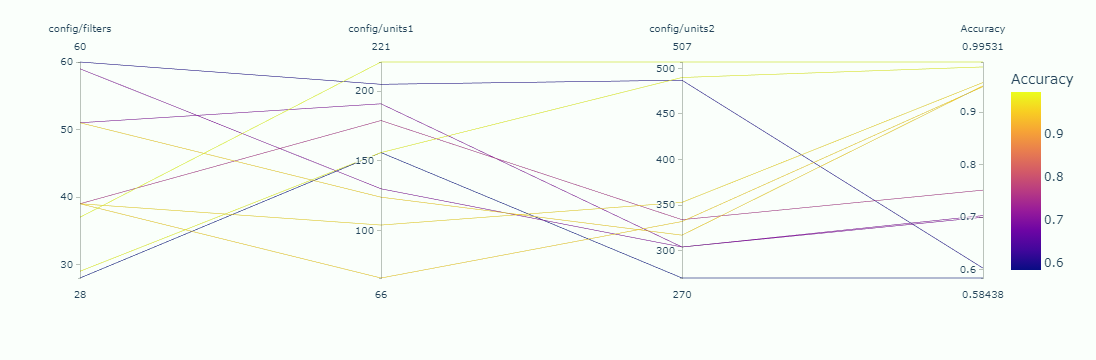

In [102]:
import plotly.express as px

plot = analysis.results_df
select2 = [ "config/filters", 'config/units1', 'config/units2',  "Accuracy"]
p2 = plot[select2].reset_index().dropna()
#sort by accuracy
p2.sort_values("Accuracy", inplace=True)
# make a parallel plot
px.parallel_coordinates(p2, color="Accuracy")

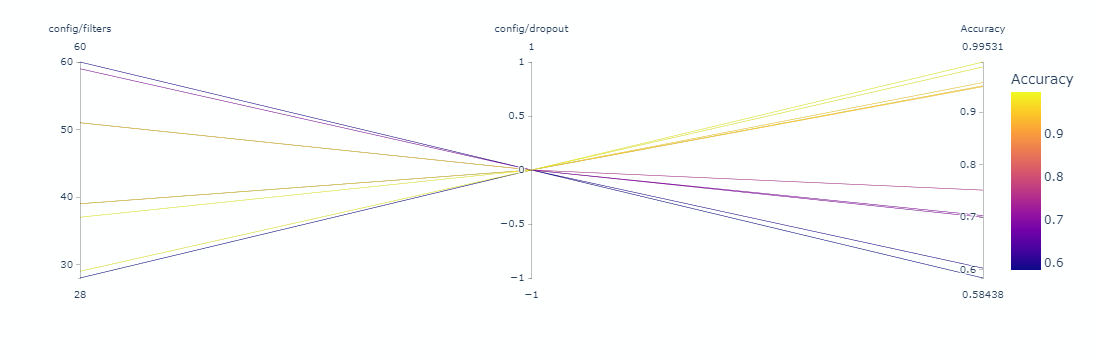

In [103]:
select = [ "config/filters", "config/dropout",  "Accuracy"]
p = plot[select].reset_index().dropna()
#sort by accuracy
p.sort_values("Accuracy", inplace=True)
# make a parallel plot
px.parallel_coordinates(p, color="Accuracy")

<Axes: xlabel='config/filters', ylabel='config/dropout'>

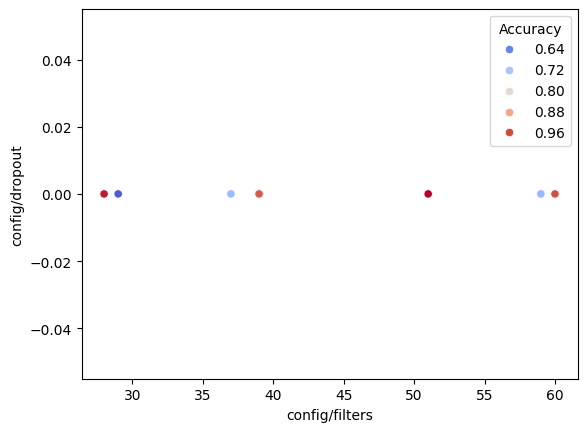

In [104]:
import seaborn as sns

sns.scatterplot(data=p, x="config/filters", y="config/dropout", hue="Accuracy", palette="coolwarm")

C:\Users\Francesca\AppData\Local\Temp\ipykernel_35020\2530808819.py:4: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.



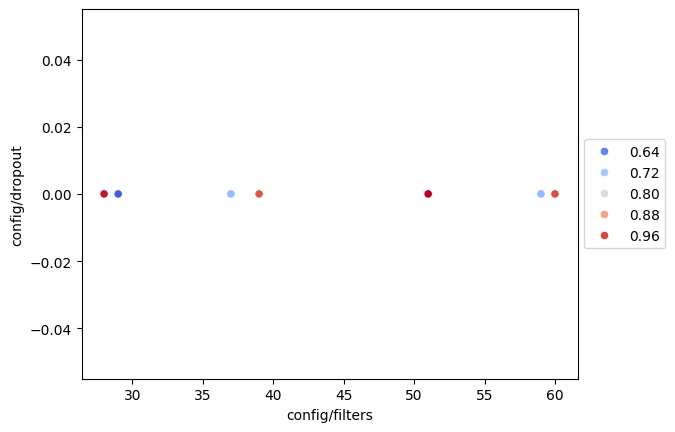

In [105]:
import matplotlib.pyplot as plt
cmap = sns.cubehelix_palette(as_cmap=True)
sns.scatterplot(data=p, x="config/filters", y="config/dropout", hue="Accuracy", palette="coolwarm")
sns.kdeplot(data=p, x="config/filters", y="config/dropout", cmap=cmap)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

Get the best trial

In [106]:
analysis.get_best_trial(metric="test_loss", mode="min")


train_4a83dc68

The top ten

In [107]:
p[-5:]


,trial_id,config/filters,config/dropout,Accuracy
7,1b658b22,39,0.0,0.948438
6,ca5e2422,51,0.0,0.950000
1,061c8747,60,0.0,0.956250
0,a237403e,28,0.0,0.985938
2,4a83dc68,51,0.0,0.995313


In [108]:
p2[-5:]

,trial_id,config/filters,config/units1,config/units2,Accuracy
7,1b658b22,39,104,353,0.948438
6,ca5e2422,51,124,317,0.950000
1,061c8747,60,205,487,0.956250
0,a237403e,28,156,270,0.985938
2,4a83dc68,51,191,304,0.995313


In [109]:
import pandas as pd
 # Merge datasets on `trial_id` and other shared columns
top5 = pd.merge(p[-5:], p2[-5:], on=["trial_id", "config/filters", "Accuracy"])
top5.sort_values('Accuracy', inplace=True, ascending=False)

In [110]:
from tabulate import tabulate
# Convert to Markdown table
markdown_table = tabulate(top5, headers="keys", tablefmt="pipe")

# Print or save the Markdown table
print(markdown_table)

|    | trial_id   |   config/filters |   config/dropout |   Accuracy |   config/units1 |   config/units2 |
|---:|:-----------|-----------------:|-----------------:|-----------:|----------------:|----------------:|
|  4 | 4a83dc68   |               51 |                0 |   0.995313 |             191 |             304 |
|  3 | a237403e   |               28 |                0 |   0.985938 |             156 |             270 |
|  2 | 061c8747   |               60 |                0 |   0.95625  |             205 |             487 |
|  1 | ca5e2422   |               51 |                0 |   0.95     |             124 |             317 |
|  0 | 1b658b22   |               39 |                0 |   0.948438 |             104 |             353 |


In [72]:
top5['Accuracy'].tolist()

[0.99375, 0.9921875, 0.9796875, 0.9546875, 0.7328125]

Or the best config

In [39]:
analysis.get_best_config(metric="Accuracy", mode="max")


{'input_size': 3,
 'output_size': 20,
 'tune_dir': WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/src/models/ray'),
 'data_dir': WindowsPath('C:/Users/Francesca/Documents/osint/code_repo/AI/MADS-MachineLearning-FP/src/data/raw/gestures/gestures-dataset'),
 'dropout': 0.09358145406066655,
 'num_layers': 3,
 'choice': 1,
 'filters': 55,
 'units1': 156,
 'units2': 316,
 'model_type': 'CNN'}

In [52]:
torchviz

NameError: name 'torchviz' is not defined